Cargando datos...
Empezando entrenamiento de eliminación de ruido...
Epoch:1, Loss:0.0454
Epoch:2, Loss:0.0318
Epoch:3, Loss:0.0294
Epoch:4, Loss:0.0266
Epoch:5, Loss:0.0240
Generando gráficas...
Imagen guardada en ./images/resultado_denoising.png


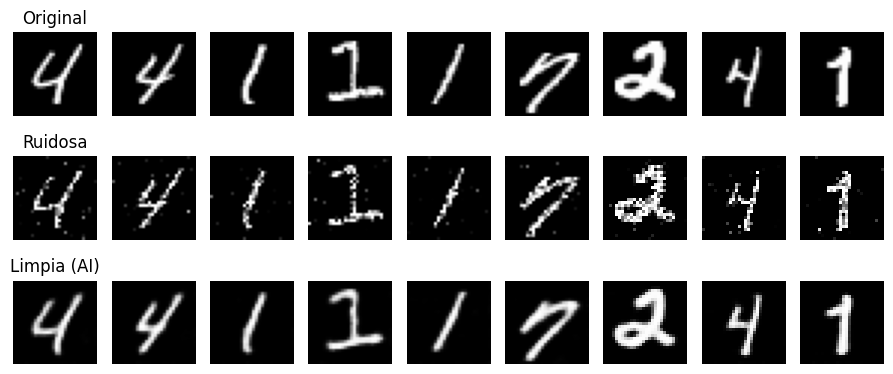

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# 1. CONFIGURACIÓN Y DATOS
# -----------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ### CAMBIO: Arreglamos el bug del transform. Solo una definición.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) 
])

print("Cargando datos...")
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
# ### CAMBIO: Usamos solo el conjunto de test para validación (más rápido y limpio)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=64, shuffle=False)

# 2. EL MODELO CONVOLUCIONAL (El "Cerebro")
# -----------------------------------------
# 2. EL MODELO CONVOLUCIONAL (CORREGIDO)
# -----------------------------------------
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()        
        # Encoder (Igual que antes)
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)                       
        )
        
        # Decoder (CON CAMBIO EN LA ÚLTIMA CAPA)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), 
            nn.Tanh()  # <--- CAMBIO AQUÍ: Sigmoid() -> Tanh()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
# Instanciamos
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)


# 3. ENTRENAMIENTO CON RUIDO (DENOISING)
# --------------------------------------
# ### CAMBIO: Función para añadir ruido
def add_noise(img, noise_factor=0.5):
    noise = torch.randn_like(img) * noise_factor
    noisy_img = img + noise
    return torch.clamp(noisy_img, 0., 1.) # Aseguramos que los valores sigan siendo válidos

num_epochs = 20 # Lo bajé a 5 para probar rápido (mejores resultados comprobados en 20)
outputs = []

print("Empezando entrenamiento de eliminación de ruido...")

for epoch in range(num_epochs):
    for (img, _) in train_loader:
        img = img.to(device)
        
        # ### CAMBIO IMPORTANTE: 
        # 1. No hacemos reshape porque es convolucional
        # 2. Generamos la imagen sucia
        noisy_img = add_noise(img)
        
        # Forward
        recon = model(noisy_img) # Entra la sucia
        loss = criterion(recon, img) # Se compara contra la LIMPIA (img)
        
        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    
    # Guardamos una muestra para pintar luego
    outputs.append((epoch, img, noisy_img, recon))


# 4. VISUALIZACIÓN (3 FILAS)
# --------------------------
print("Generando gráficas...")
# Tomamos la última época para visualizar
img_orig = outputs[-1][1].cpu().detach().numpy()
img_noisy = outputs[-1][2].cpu().detach().numpy()
img_recon = outputs[-1][3].cpu().detach().numpy()

plt.figure(figsize=(9, 4))
plt.gray()

# Mostramos 9 ejemplos
for i in range(9):
    # Fila 1: Originales
    plt.subplot(3, 9, i+1)
    plt.imshow(img_orig[i][0])
    if i == 0: plt.title("Original")
    plt.axis('off')
    
    # Fila 2: Con Ruido (Input)
    plt.subplot(3, 9, i+10)
    plt.imshow(img_noisy[i][0])
    if i == 0: plt.title("Ruidosa")
    plt.axis('off')

    # Fila 3: Reconstrucción (Output)
    plt.subplot(3, 9, i+19)
    plt.imshow(img_recon[i][0])
    if i == 0: plt.title("Limpia (AI)")
    plt.axis('off')

plt.tight_layout()


import os
if not os.path.exists('./images'): os.makedirs('./images') # Crea la carpeta si no existe
plt.savefig('./images/resultado_denoising.png')
print("Imagen guardada en ./images/resultado_denoising.png")
# -----------------------------------

plt.show()

Entrenando Modelo de Superresolución (Input 7x7 -> Output 28x28)...
Epoch:1, Loss:0.0897
Epoch:2, Loss:0.0906
Epoch:3, Loss:0.0802
Epoch:4, Loss:0.0740
Epoch:5, Loss:0.0731
Generando gráficas de Superresolución...
Imagen guardada en ./images/resultado_superresolucion.png


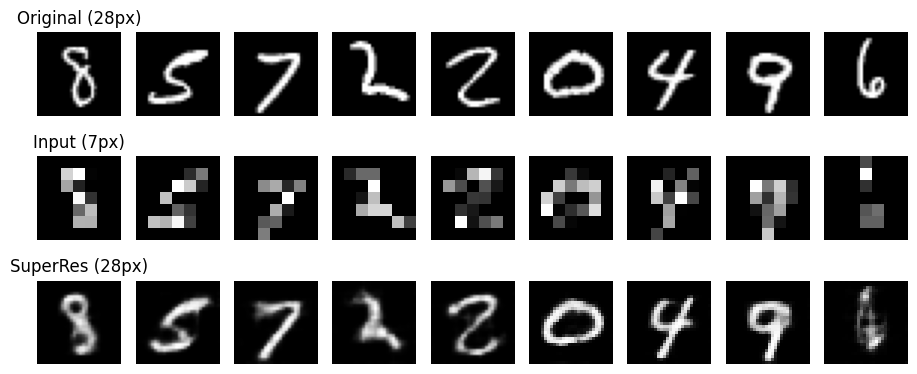

In [ ]:
# ==========================================
# TAREA B: SUPERRESOLUCIÓN (7x7 -> 28x28)
# ==========================================

# 1. Definiendo el modelo de Superresolución
class AutoencoderSR(nn.Module):
    def __init__(self):
        super().__init__()
        
        # --- NUEVO ENCODER ---
        # La entrada ahora será pequeña (7x7). 
        # Ya no necesitamos reducir tanto (pooling/strides), solo extraer características.
        self.encoder = nn.Sequential(
            # Entrada: (N, 1, 7, 7)
            nn.Conv2d(1, 32, 3, padding=1),  # -> Mantiene tamaño (N, 32, 7, 7)
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)             # -> Colapsa a (N, 64, 1, 1) (Espacio latente)
        )
        
        # --- MISMO DECODER ---
        # El decoder original ya sabe ir de (1x1) a (28x28), así que lo reutilizamos tal cual.
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),             # -> (N, 32, 7, 7)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # -> (N, 16, 14, 14)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),  # -> (N, 1, 28, 28)
            nn.Tanh() # Usamos Tanh igual que antes
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Instanciamos el modelo SR
model_sr = AutoencoderSR().to(device)
optimizer_sr = torch.optim.Adam(model_sr.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = nn.MSELoss()

# 2. Función para reducir la imagen (Simular baja resolución)
def make_low_res(img, size=7):
    # Interpolamos (redimensionamos) a 7x7
    low_res = torch.nn.functional.interpolate(img, size=(size, size), mode='bilinear', align_corners=False)
    return low_res

print("Entrenando Modelo de Superresolución (Input 7x7 -> Output 28x28)...")

# 3. Bucle de Entrenamiento
num_epochs = 20
outputs_sr = []

for epoch in range(num_epochs):
    for (img_high_res, _) in train_loader: # img_high_res es la original 28x28
        img_high_res = img_high_res.to(device)
        
        # Creamos la entrada pequeña
        img_low_res = make_low_res(img_high_res, size=7)
        
        # Forward
        recon = model_sr(img_low_res)   # Entra la pequeña (7x7)
        loss = criterion(recon, img_high_res) # Comparamos con la GRANDE (28x28)
        
        # Backward
        optimizer_sr.zero_grad()
        loss.backward()
        optimizer_sr.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs_sr.append((epoch, img_high_res, img_low_res, recon))

# 4. Visualización
print("Generando gráficas de Superresolución...")
img_orig = outputs_sr[-1][1].cpu().detach().numpy()
img_input = outputs_sr[-1][2].cpu().detach().numpy() # Estas serán de 7x7
img_recon = outputs_sr[-1][3].cpu().detach().numpy() # Estas serán de 28x28

plt.figure(figsize=(9, 4))
plt.gray()

for i in range(9):
    # Fila 1: Original (High Res)
    plt.subplot(3, 9, i+1)
    plt.imshow(img_orig[i][0])
    if i == 0: plt.title("Original (28px)")
    plt.axis('off')
    
    # Fila 2: Entrada (Low Res 7x7)
    plt.subplot(3, 9, i+10)
    plt.imshow(img_input[i][0])
    if i == 0: plt.title("Input (7px)")
    plt.axis('off')

    # Fila 3: Superresolución (AI)
    plt.subplot(3, 9, i+19)
    plt.imshow(img_recon[i][0])
    if i == 0: plt.title("SuperRes (28px)")
    plt.axis('off')

plt.tight_layout()



# ### NUEVO: GUARDAR IMAGEN EN DISCO
if not os.path.exists('./images'): os.makedirs('./images')
plt.savefig('./images/resultado_superresolucion.png')
print("Imagen guardada en ./images/resultado_superresolucion.png")
# -----------------------------------
plt.show()